In [572]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0
from scipy.special import ellipk,ellipe
from mpl_toolkits import mplot3d


class jmesh:
    """

        mesh object with discretized operators

    """

    def __init__(self, n1, n2, n3, h1, h2, h3):
        """

            initialize mesh

        """

        self.n1 = n1
        self.n2 = n2
        self.n3 = n3
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        
        n1 = n1 + 1
        n2 = n2 + 1
        n3 = n3 + 1
        
        # define single parameters
        self.number_of_cells = n1 * n2 * n3
        
        # define the nodal grid
        x_nodal = np.arange(n1) * h1
        y_nodal = np.arange(n2) * h2
        z_nodal = np.arange(n3) * h3

        X_nodal,Y_nodal,Z_nodal = np.meshgrid(x_nodal[0,:], y_nodal[0,:],z_nodal[0,:])
        self.plotx, self.ploty, self.plotz = X_nodal,Y_nodal,Z_nodal
        
        self.vector_of_node_grid_x = X_nodal.flatten()
        self.vector_of_node_grid_y = Y_nodal.flatten()
        self.vector_of_node_grid_z = Z_nodal.flatten()
        
        # define cell centered grid
        x_center = (np.arange(n1-1) + 0.5) * h1
        y_center = (np.arange(n2-1) + 0.5) * h2
        z_center = (np.arange(n3-1) + 0.5) * h3

        X_center,Y_center,Z_center = np.meshgrid(x_center[0,:], y_center[0,:],z_center[0,:])
        
        self.vector_of_cell_centered_grid_x = X_center.flatten()
        self.vector_of_cell_centered_grid_y = Y_center.flatten()
        self.vector_of_cell_centered_grid_z = Z_center.flatten()

        
        # ------------------------------------------------------------------

        # do the x edges

        #
        
        x_edge1 = ((np.arange(n1 - 1) + 0.5) * h1)[0, :]
        y_edge1 = ((np.arange(n2)) * h2)[0, :]
        z_edge1 = ((np.arange(n3)) * h3)[0, :]

        x_edge = []

        for ii in range(z_edge1.shape[0]):

            for jj in range(y_edge1.shape[0]):

                for kk in range(x_edge1.shape[0]):

                    x_edge.append([x_edge1[kk], y_edge1[jj], z_edge1[ii]])


        self.x_edges = np.asarray(x_edge)

        # ------------------------------------------------------------------

        # do the y edges

        #

        x_edge2 = ((np.arange(n1)) * h1)[0, :]
        y_edge2 = ((np.arange(n2 - 1) + 0.5) * h2)[0, :]
        z_edge2 = ((np.arange(n3)) * h3)[0, :]

        y_edge = []

        for ii in range(z_edge2.shape[0]):

            for jj in range(y_edge2.shape[0]):

                for kk in range(x_edge2.shape[0]):

                    y_edge.append([x_edge2[kk], y_edge2[jj], z_edge2[ii]])


        self.y_edges = np.asarray(y_edge)

        # ------------------------------------------------------------------

        # do the z edges

        #

        x_edge3 = ((np.arange(n1)) * h1)[0, :]
        y_edge3 = ((np.arange(n2)) * h2)[0, :]
        z_edge3 = ((np.arange(n3 - 1) + 0.5) * h3)[0, :]

        z_edges = []

        for ii in range(z_edge3.shape[0]):

            for jj in range(y_edge3.shape[0]):

                for kk in range(x_edge3.shape[0]):

                    z_edges.append([x_edge3[kk], y_edge3[jj], z_edge3[ii]])


        self.z_edges = np.asarray(z_edges)
        
        # ------------------------------------------------------------------

        # do the x faces

        #
        
        x_face1 = ((np.arange(n1 - 1) + 0.5) * h1)[0, :]
        y_face1 = ((np.arange(n2)) * h2)[0, :]
        z_face1 = ((np.arange(n3 - 1) + 0.5) * h3)[0, :]

        x_face = []

        for ii in range(z_face1.shape[0]):

            for jj in range(y_face1.shape[0]):

                for kk in range(x_face1.shape[0]):

                    x_face.append([x_face1[kk], y_face1[jj], z_face1[ii]])


        self.x_faces = np.asarray(x_face)
        
        # ------------------------------------------------------------------

        # do the y faces

        #
        
        x_face2 = (np.arange(n1) * h1)[0, :]
        y_face2 = ((np.arange(n2 - 1) + 0.5) * h2)[0, :]
        z_face2 = ((np.arange(n3 - 1) + 0.5) * h3)[0, :]
        
        y_faces = []

        for ii in range(z_face2.shape[0]):

            for jj in range(y_face2.shape[0]):

                for kk in range(x_face2.shape[0]):

                    y_faces.append([x_face2[kk], y_face2[jj], z_face2[ii]])


        self.y_faces = np.asarray(y_faces)
        
        # ------------------------------------------------------------------

        # do the z faces

        #
        
        x_face3 = ((np.arange(n1 - 1 ) + 0.5) * h1)[0, :]
        y_face3 = ((np.arange(n2 - 1) + 0.5) * h2)[0, :]
        z_face3 = (np.arange(n3) * h3)[0, :]

        z_faces = []

        for ii in range(z_face3.shape[0]):

            for jj in range(y_face3.shape[0]):

                for kk in range(x_face3.shape[0]):

                    z_faces.append([x_face3[kk], y_face3[jj], z_face3[ii]])


        self.z_faces = np.asarray(z_faces)       


    def getFaceDivergenceMatrix(self):
        """

            calculates the divergance operator on the faces

        """

        n1,n2,n3 = self.n1, self.n2, self.n3
        
        def ddx(n):
            return sp.spdiags((np.ones([n+1,1])*np.array([-1,1])).T,[0,1],n,n+1)
        
        D1 = sp.kron(sp.eye(n3),sp.kron(sp.eye(n2),ddx(n1)))
        D2 = sp.kron(sp.eye(n3),sp.kron(ddx(n2),sp.eye(n1)))
        D3 = sp.kron(ddx(n3),sp.kron(sp.eye(n2),sp.eye(n1)))

        #  DIV from faces to cell-centers
        Div = [D1, D2, D3]

        return sp.hstack(Div)


    def getNodalGradientMatrix(self):
        """

            calculates the gradient matrix

        """

        n1,n2,n3 = self.n1, self.n2, self.n3
        
        def ddx(n):
            return sp.spdiags((np.ones([n+1,1])*np.array([-1,1])).T,[0,1],n,n+1)
        
        G1 = sp.kron(sp.eye(n3+1), sp.kron(sp.eye(n2+1),ddx(n1)))
        G2 = sp.kron(sp.eye(n3+1), sp.kron(ddx(n2),sp.eye(n1+1)))
        G3 = sp.kron(ddx(n3),sp.kron(sp.eye(n2+1),sp.eye(n1+1)))
        # grad on the nodes
        Grad = sp.vstack([G1, G2, G3])

        return Grad
    
    def getEdgeCurlMatrix(self):
        """

            calculates the curl matrix operator

        """
        
        n1,n2,n3 = self.n1, self.n2, self.n3
        
        def ddx(n):
            return sp.spdiags((np.ones((n + 1, 1)) * [-1, 1]).T, [0, 1], n, n + 1, format="csr") # sp.spdiags((np.ones([n+1,1])*[-1,1]).T,[0,1],n,n+1)

        nfx = (n1 + 1) * n2 * n3
        nfy = n1 * (n2 + 1) * n3
        nfz = n1 * n2 * (n3 + 1)
        nex = n1 * (n2 + 1) * (n3 + 1)
        ney = (n1 + 1) * n2 * (n3 + 1)
        nez = (n1 + 1) * (n2 + 1) * n3
            
        Dyz = sp.kron(ddx(n3), sp.kron(sp.eye(n2), sp.eye(n1 + 1)))
        Dzy = sp.kron(sp.eye(n3), sp.kron(ddx(n2), sp.eye(n1 + 1)))
        
        Dxz = sp.kron(ddx(n3),sp.kron(sp.eye(n2+1),sp.eye(n1)))
        Dzx = sp.kron(sp.eye(n3),sp.kron(sp.eye(n2 + 1), ddx(n1)))
        
        Dxy = sp.kron(sp.eye(n3 + 1), sp.kron(ddx(n2),sp.eye(n1)))
        Dyx = sp.kron(sp.eye(n3+1), sp.kron(sp.eye(n2), ddx(n1)))

        # curl on the edges
        Curl = sp.vstack(
            [sp.hstack([sp.dia_matrix((nfx,nex)), Dyz, -Dzy]),
             sp.hstack([-Dxz, sp.dia_matrix((nfy,ney)), Dzx]),
             sp.hstack([Dxy, -Dyx  , sp.dia_matrix((nfz,nez))])
             ]
        )

        return Curl

    def getMeshGeometry(self):

        h1, h2, h3 = self.h1.T, self.h2.T, self.h3.T

        n1 = h1.size
        n2 = h2.size
        n3 = h3.size
        
        V = sp.kron(sp.diags(h3, [0]), sp.kron(sp.diags(h2, [0]), sp.diags(h1, [0])))
        
        F = sp.diags(sp.hstack([sp.kron(sp.diags(h3, [0]), sp.kron(sp.diags(h2, [0]), sp.eye(n1+1))).diagonal(),
             sp.kron(sp.diags(h3, [0]), sp.kron(sp.eye(n2 + 1), sp.diags(h1, [0]))).diagonal(),
             sp.kron(sp.eye(n3 + 1), sp.kron(sp.diags(h2, [0]),sp.diags(h1, [0]))).diagonal()]).toarray(), [0])
        
        L = sp.diags(sp.hstack([
            sp.kron(sp.eye(n3 + 1), sp.kron(sp.eye(n2 + 1), sp.diags(h1, [0]))).diagonal(),
            sp.kron(sp.eye(n3 + 1), sp.kron(sp.diags(h2, [0]), sp.eye(n1 + 1))).diagonal(),
            sp.kron(sp.diags(h3, [0]), sp.kron(sp.eye(n2 + 1), sp.eye(n1 + 1))).diagonal()]).toarray(), [0]
         )
        
        return V, F, L

    def getFaceToCellCenterMatrix(self):

        n1,n2,n3 = self.n1, self.n2, self.n3

        def av(n):
            return sp.spdiags((np.ones([n+1,1])*np.array([0.5,0.5])).T,[0,1],n,n+1)

        A1 = sp.kron(sp.eye(n3),sp.kron(sp.eye(n2),av(n1)))
        A2 = sp.kron(sp.eye(n3),sp.kron(av(n2),sp.eye(n1)))
        A3 = sp.kron(av(n3),sp.kron(sp.eye(n2),sp.eye(n1)))
        # average from faces to cell-centers
        Afc = sp.hstack([A1, A2, A3])

        return Afc

    def getEdgeToCellCenterMatrix(self):

        def av(n):
            return sp.spdiags((np.ones([n+1,1])*np.array([0.5,0.5])).T,[0,1],n,n+1)

        A1 = sp.kron(av(n3),sp.kron(av(n2),sp.eye(n1)))
        A2 = sp.kron(av(n3),sp.kron(sp.eye(n2),av(n1)))
        A3 = sp.kron(sp.eye(n3),sp.kron(av(n2),av(n1)))

        # average from edge to cell-centers
        Aec = sp.hstack([A1,A2,A3])

        return Aec

    def getNodalToCellCenterMatrix(self):

        def av(n):
            return sp.spdiags((np.ones([n+1,1])*np.array([0.5,0.5])).T,[0,1],n,n+1)

        Anc = sp.kron(av(n3), sp.kron(av(n2),av(n1)))

        return Anc

# plt.spy(mesh.getMeshGeometry())
# plt.show()
# print(sp.kron(sp.diags(h3.T, [0]), sp.kron(sp.eye(n2 + 1), sp.diags(h1.T, [0]))).diagonal())
#  sp.kron(sp.diags(h2.T, 1), sp.diags(h1.T, 1)))


## Mesh

<IPython.core.display.Javascript object>


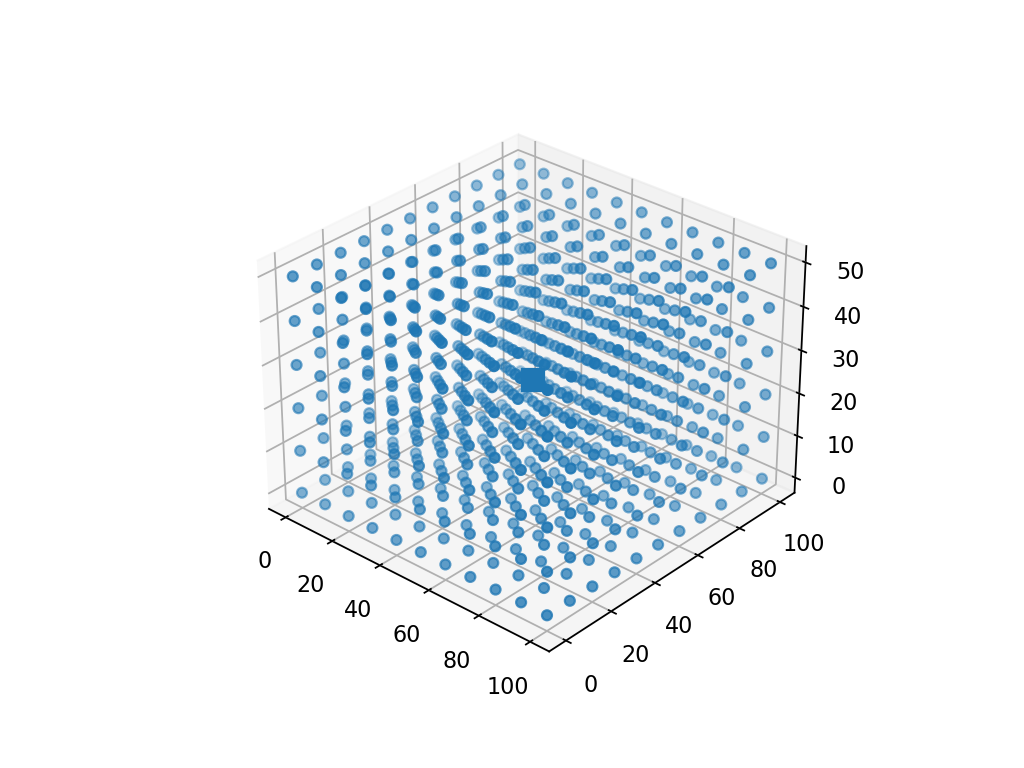

In [571]:
%matplotlib notebook

# create the discretixed mesh
n1=10
n2=10
n3=5
h1=10 * np.ones((n1, 1))
h2=10 * np.ones((n2, 1))
h3=10 * np.ones((n3, 1))
mesh = jmesh(n1, n2, n3, h1, h2, h3)

sigma = np.random.rand(n1,n2,n3)*0.1
mu    = np.ones((n1*n2*n3))*4*np.pi*1e-7;

X = mesh.vector_of_node_grid_x
Y = mesh.vector_of_node_grid_y
Z = mesh.vector_of_node_grid_z
ax = plt.axes(projection='3d')
ax.scatter(X,Y,Z) # plot the point (2,3,4) on the figure

## Sources

In [561]:
def vectorPotential_circularloop(a,obsloc,I=1.):
    """

    Compute the vector potential A response of a current loop
    
    From Simpson, Lane, Immer, Youngquist 2001
    
    """
    x = obsloc[:,0]
    y = obsloc[:,1]
    z = obsloc[:,2]

    #Conversion to spherical coordinates
    r = np.linalg.norm(obsloc,axis=1)
    theta = np.arccos(z/r)
    phi = np.arctan2(y,x)
    te0 = a**2.+r**2.+2.*a*r*np.sin(theta)
    k2 = (4.*a*r*np.sin(theta))/te0
    C = mu_0*I*a/(np.pi)
    te1 = 1./np.sqrt(te0)
    te2 = ((2.-k2)*ellipk(k2)-2.*ellipe(k2))/k2

    Aphi = C*te1*te2
    Aphi[np.isnan(Aphi)] = 0.

    Ax = -np.sin(phi)*Aphi
    Ay = np.cos(phi)*Aphi
    Az = np.zeros_like(Aphi)
    print(Ax.shape, Ay.shape, Az.shape) 
    A = np.vstack([Ax,Ay,Az]).T

    return A

def circularloop(a,obsloc,current_I=1.):
    """
    
    Compute the magnetic field B response of a current loop
    
    From Simpson, Lane, Immer, Youngquist 2001

    """
    x = obsloc[:,0].T
    y = obsloc[:,1].T
    z = obsloc[:,2].T

    r = np.linalg.norm(obsloc,axis=1)
    n,d = obsloc.shape
    r2 = x**2.+y**2.+z**2.
    rho2 = x**2.+y**2.
    alpha2 = a**2.+r2-2*a*np.sqrt(rho2)
    beta2 = a**2.+r2+2*a*np.sqrt(rho2)
    k2 = 1-(alpha2/beta2)
    lbda = x**2.-y**2.
    C = mu_0*I/np.pi

    Bx = ((C*x*z)/(2*alpha2*np.sqrt(beta2)*rho2))*\
    ((a**2.+r2)*ellipe(k2)-alpha2*ellipk(k2))
    Bx[np.isnan(Bx)] = 0.

    By = ((C*y*z)/(2*alpha2*np.sqrt(beta2)*rho2))*\
    ((a**2.+r2)*ellipe(k2)-alpha2*ellipk(k2))
    By[np.isnan(By)] = 0.

    Bz = (C/(2.*alpha2*np.sqrt(beta2)))*\
    ((a**2.-r2)*ellipe(k2)+alpha2*ellipk(k2))
    Bz[np.isnan(Bz)] = 0.

    B = np.hstack([Bx,By,Bz])

    return B

In [626]:

"""
Test the linear convergence of Backward Euler
in comparison to the analytic solution for B
for a cicular loop
"""

PlotIt = True

#Define the model


sigma = np.ones(500) * 1e-2
# air = mesh.gridC[:,2]>0.
# m[air] = 1e-8

#Source Loop
radius = 10.

#Receiver
rx_locations = np.r_[[[20.,20.,50.]]]
observation_locations = np.r_[[[50.,50.,50.]]]
listF = np.vstack([mesh.x_faces,mesh.y_faces,mesh.z_faces])
obsindex =np.argmin(np.linalg.norm(listF-observation_locations,axis=1))

#Initialize B

# get mesh geometry
V,F,L = mesh.getMeshGeometry()
CURL = mesh.getEdgeCurlMatrix()
DIV  = mesh.getFaceDivergenceMatrix()
GRAD = mesh.getNodalGradientMatrix()
DIV = spsolve(V,(DIV@F))
GRAD = spsolve(L,GRAD)
CURL = spsolve(F,(CURL@L))

Aloopx = vectorPotential_circularloop(radius,mesh.x_edges)
Aloopy = vectorPotential_circularloop(radius,mesh.y_edges)
Aloopz = vectorPotential_circularloop(radius,mesh.z_edges)
AloopE = np.r_[Aloopx[:,0],Aloopy[:,1],Aloopz[:,2]]
# print(AloopE.shape, CURL.shape)
BloopF_t0 = CURL @ AloopE
# Bt0_analytic = mu_0/(2*radius)
# print('relative error at initialization: ',np.abs(BloopF_t0[obsindex]-Bt0_analytic)/np.abs(Bt0_analytic))
# print(BloopF_t0[obsindex], Bt0_analytic, np.abs(Bt0_analytic))

#Initialize list
Bbslist = []
errorlist=[]
plist = []
klist = []

#Final Time and number of time steps to reach it
timetarget = 1e-4
timesteps = range(10,51,10)

#Analytic
# Bz =mu_0*hzAnalyticCentLoopT(radius,timetarget,sighalf)
# print('Analytic solution Bz for time %f s: '%(timetarget),Bz)

# construct the inner productors
Af   = mesh.getFaceToCellCenterMatrix()
Ae   = mesh.getEdgeToCellCenterMatrix()
An   = mesh.getNodalToCellCenterMatrix()

# set up mass matrices
Mmuinv  = sp.diags(Af.T*(V*(1./mu)))
Msig    = sp.diags(Ae.T*(V*sigma))
Mmuinvn = sp.diags(An.T*V*(1./mu))

# initial conditions
b0   = BloopF_t0
e0   = spsolve(Msig, (CURL.T*Mmuinv*b0))
dt   = np.ones((20,1))*5e-4
e = np.zeros((e0.shape[0], dt.shape[0]))
e[:,0] = e0
print(e0.shape)
# time step
for i in range(dt.shape[0]):
    # The linear system to be solved
    Ke = CURL.T@Mmuinv@CURL + (1/dt[i])[0]*Msig
    # solve
    rhs = (1/dt[i])[0]*Msig*e[:,i]
#     e[:,i+1] = solveSystem(Ke,Msig,Mmuinvn,Grad,dt(i),rhs)
#     # compute the data
#     d[:,i] = param.obs*Curl*e(:,i+1);end

(660,) (660,) (660,)
(660,) (660,) (660,)
(605,) (605,) (605,)
(1925,)


/var/folders/53/tg9ck_q118gdnyf_pmn3jfxc0000gn/T/ipykernel_87839/3672828668.py:21: RuntimeWarning: invalid value encountered in true_divide
  te2 = ((2.-k2)*ellipk(k2)-2.*ellipe(k2))/k2


In [598]:
x_center = (np.arange(n1-1) + 0.5) * h1
y_center = (np.arange(n2-1) + 0.5) * h2
# z_center = (np.arange(n3-1) + 0.5) * h3
x_r, y_r = np.meshgrid(x_center[0,:], y_center[0,:])
x_r = x_r.flatten()
y_r = y_r.flatten()
z_r = np.ones(81) * 50.0
# x_r, y_r, z_r = x_center[0,:], y_center[0,:],z_center[0,:]
observation_locations = np.vstack([x_r,y_r,z_r]).T
print(observation_locations.shape)
listF = np.vstack([mesh.x_faces,mesh.y_faces,mesh.z_faces])
obsindex =np.argmin(np.linalg.norm(listF-observation_locations,axis=1))
# BloopF_t0.shape
# plt.plot(observation_locations[0, :], observation_locations[1, :], '.')
# plt.scatter(x, y, s=area, c=colors, alpha=0.5)
# plt.show()

(81, 3)


ValueError: operands could not be broadcast together with shapes (1700,3) (81,3) 

In [543]:
def magnetostaticsCurrentLoop(X, a, x0):
    # Compute magnetic vector potential of horizontal circular current loop
    # of radius a located at the origin.
    n = size(X, 1)
    x = X[:, 1] - x0[1] 
    y = X[:, 2] - x0[2]
    z = X[:, 3] - x0[3]
    r = sqrt(x^2 + y^2)
    m=(4 * a * r) / ((a + r)^2 + z^2)
    m[m > 1] = 1
    # m might be slightly larger than 1 due to rounding errors
    # but ellipke requires 0 <= m <= 1
    [K, E] = ellipke(m)
    i = r > 0 & m < 1
    # r singular at r = 0 and K(m) singular at m = 1
    Aphi = np.zeros[n, 1]
    Ax   = np.zeros[n, 1]
    Ay   = np.zeros[n, 1]
    Az   = np.zeros[n, 1]
    # Common factor is (mu*I)/piwithI=1andmu=4e-7*pi.
    Aphi[i] = 4e-7 / sqrt(m[i]) * sqrt(a / r[i]) * ((1-m[i]/2) * K[i] - E[i])
    Ax[i]   = Aphi[i] * (-y[i] / r[i])
    Ay[i]   = Aphi[i] * ( x[i] / r[i])

    return np.asarray([Ax, Ay, Az])

